# Subclustering of Post. Midgut/ Hindgut/ Ecto. PS14 in Integration data

In [1]:
#loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)
library(harmony)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_0.1.0     Rcpp_1.0.7        tibble_3.0.5      dplyr_1.0.3      
[5] Matrix_1.3-2      data.table_1.13.6 magrittr_2.0.1    ggplot2_3.3.3    
[9] Seurat_3.2.3     

loaded via a namespace (and not attached):
 [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
 [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
 [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
[10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18

In [3]:
func.centering <- function(seu){
    DefaultAssay(seu) <- 'SCT'
    scale.data <- GetAssayData(seu, assay = 'SCT', slot = 'scale.data') #Get scale.data
    new.data <- ScaleData(object = scale.data, do.scale = F, do.center = T) #centering scale.data
    
    seu <- SetAssayData(object = seu, assay = 'SCT',
                        slot = 'scale.data', new.data = new.data) #insert centering data into scale.data slot
    return(seu)
    
}

func.normalize <- function(seu){
    
    if(dim(seu)[2]>=500){
        #Re-Normalize data only when the number of cell in the target clusters > 500.
        DefaultAssay(seu) <- 'RNA'
        if(seu$set[1]=='Set 1'){
            vars.to.regress <- c("percent.mt", "percent.rRNA","percent.ERCC")
        }else{
            vars.to.regress <- c("percent.mt", "percent.rRNA")
        }
        seu <- suppressWarnings(SCTransform(seu, vars.to.regress = vars.to.regress))
    }else{
        #If The number of cells < 500, re-normalization is skipped and only centering is performed.
        seu <- func.centering(seu)
    }
    return(seu)
}

func.subclustering.prep <- function(seu){
    obj.list <- SplitObject(seu, split.by = 'set')
    
    print(obj.list)
    
    obj.list <- lapply(X = obj.list, FUN = func.normalize)
    print(obj.list)
    integration.features <- SelectIntegrationFeatures(object.list = obj.list, nfeatures = 3000)
    seu <- merge(x = obj.list[['Set 3']], y = c(obj.list[['Set 2']],obj.list[['Set 1']],obj.list[['NK-data']]))
    VariableFeatures(seu) <- integration.features
    seu <- RunPCA(seu)
    seu <- RunHarmony(object = seu, group.by.vars = 'set', assay.use="SCT")
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'harmony')
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'pca', reduction.name = 'umapwoharmony')

    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umapwoharmony', group.by = 'set') + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    
    print(seu)
    return(seu)
}

func.subclustering <- function(seu, resolution=0.8){
    seu <- FindNeighbors(seu, dims = 1:30, reduction = 'harmony')
    seu <- FindClusters(seu, resolution = resolution)
    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umap', label = T) + NoLegend() + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    return(seu)
}

In [4]:
#loading data
seu_HQC <- readRDS(file = '../../data/seurat_object/all_integration/seu_Harmony_integrated.obj')
seu_HQC

An object of class Seurat 
25136 features across 13467 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


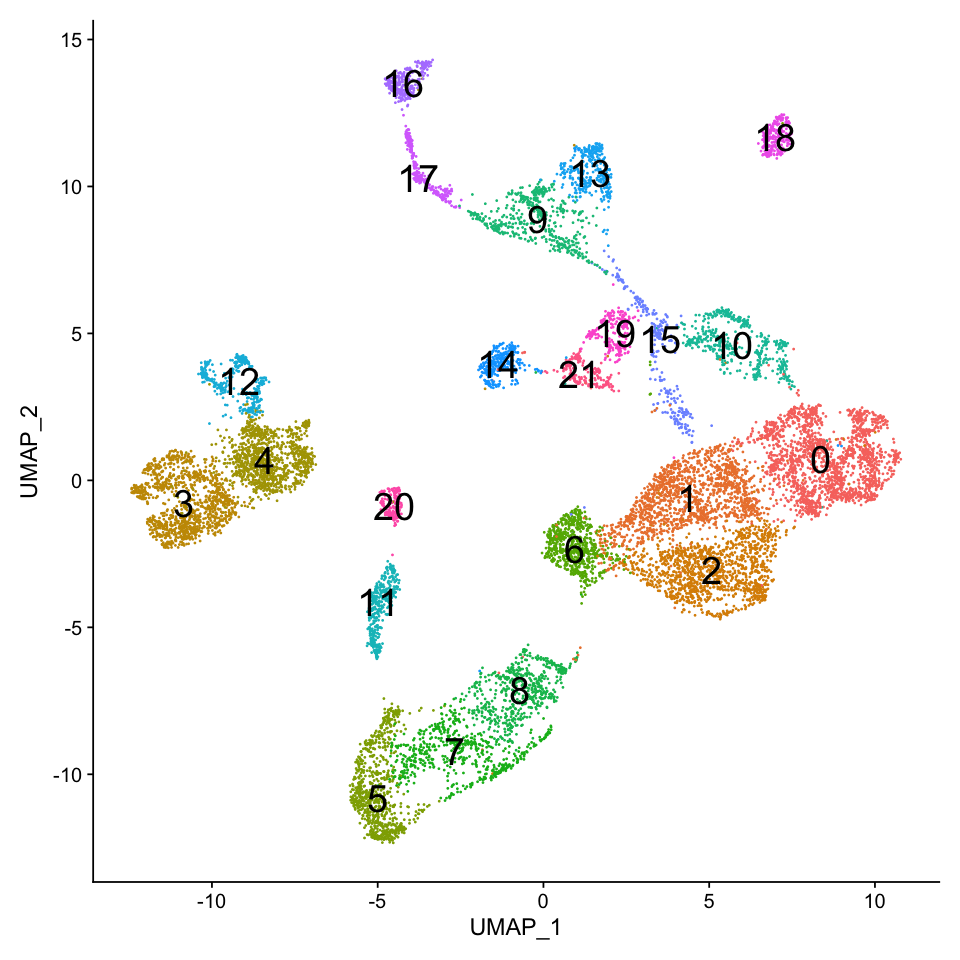

In [5]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC, reduction = 'umap', label = TRUE, label.size = 8) + NoLegend()

## Picking up target clusters

In [6]:
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c(5,7,8))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle(
        'Cluster 8: Ectoderm_PS14\nCluster 7: Hindgut\nCluster 5:Posterior_midgut'
        )

In [7]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, features = c('fkh','hkb','byn','Abd-B'))

In [8]:
seu.post <- subset(seu_HQC, idents = c(5,7,8))
seu.post$cluster.allcell <- seu.post$seurat_clusters
seu.post

An object of class Seurat 
25136 features across 1966 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

## Clustering

In [9]:
seu.post <- func.subclustering.prep(seu.post)

$`Set 3`
An object of class Seurat 
25136 features across 924 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
25136 features across 681 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 187 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 174 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 9032 by 924

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 924 cells



  |======================================================================| 100%


Found 121 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 9032 genes



  |======================================================================| 100%


Computing corrected count matrix for 9032 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 10.62962 secs

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, percent.rRNA

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 8482 by 681

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 681 cells



  |======================================================================| 100%


Found 127 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 8482 genes



  |======================================================================| 100%


Computing corrected count matrix for 8482 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 7.719217 secs

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, percent.rRNA

Centering data matrix

Set default assay to SCT

Centering data matrix

Centering data matrix



$`Set 3`
An object of class Seurat 
21600 features across 924 samples within 2 assays 
Active assay: SCT (9032 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
21050 features across 681 samples within 2 assays 
Active assay: SCT (8482 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 187 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 174 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 77 features requested have not been scaled (running reduction without them): Pepck-CG45087, CG43737, lbe, Nox, CNT2, CG4456, m, CG10657, dpr3, TpnC73F, Zw, NAAT1, lmd, vri, Osi22, CG14118, lncRNA:CR44326, CG42750, CG43980, salt, CG3168, Obp85a, CG32320, lncRNA:CR45736, lncRNA:CR45820, CG18635, CR43105, CG15544, lncRNA:CR44913, fng, B9d2, CG6026, CG12522, Lrp4, lncRNA:CR44221, CG32655, CG10730, Cpr64Ad, lncRNA:CR43640, CG15449, asRNA:CR45807, asRNA:CR45468, lncRNA:CR44737, lncRNA:CR45433, Dhc36C, knk, Snoo, tbrd-2, CG32121, sens-2, CG34216, CG18327, Ir60b, asRNA:CR44049, rols, CG42566, Cyp4ad1, CG11029, CG18545, lncRNA:CR44082, LS2, CG31778, gom, CG17139-CG17140, lncRNA:CR44171, Oatp26F, Gpb5, CG5646, lncRNA:CR45179, CG33272, CG7966, asRNA:CR44065, asRNA:CR44340, CG5810, lncRNA:CR44357, Npc2e, Prosalpha1”
PC_ 1 
Positive:  salm, ken, Blimp-1, Abd-B, robo2, trn, dpn, ftz, Ppa, D 
	   wb, we

An object of class Seurat 
25136 features across 1966 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, umap, umapwoharmony


In [10]:
seu.post <- func.subclustering(seu.post)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1966
Number of edges: 77444

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7696
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1966
Number of edges: 77444

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7132
Number of communities: 11
Elapsed time: 0 seconds


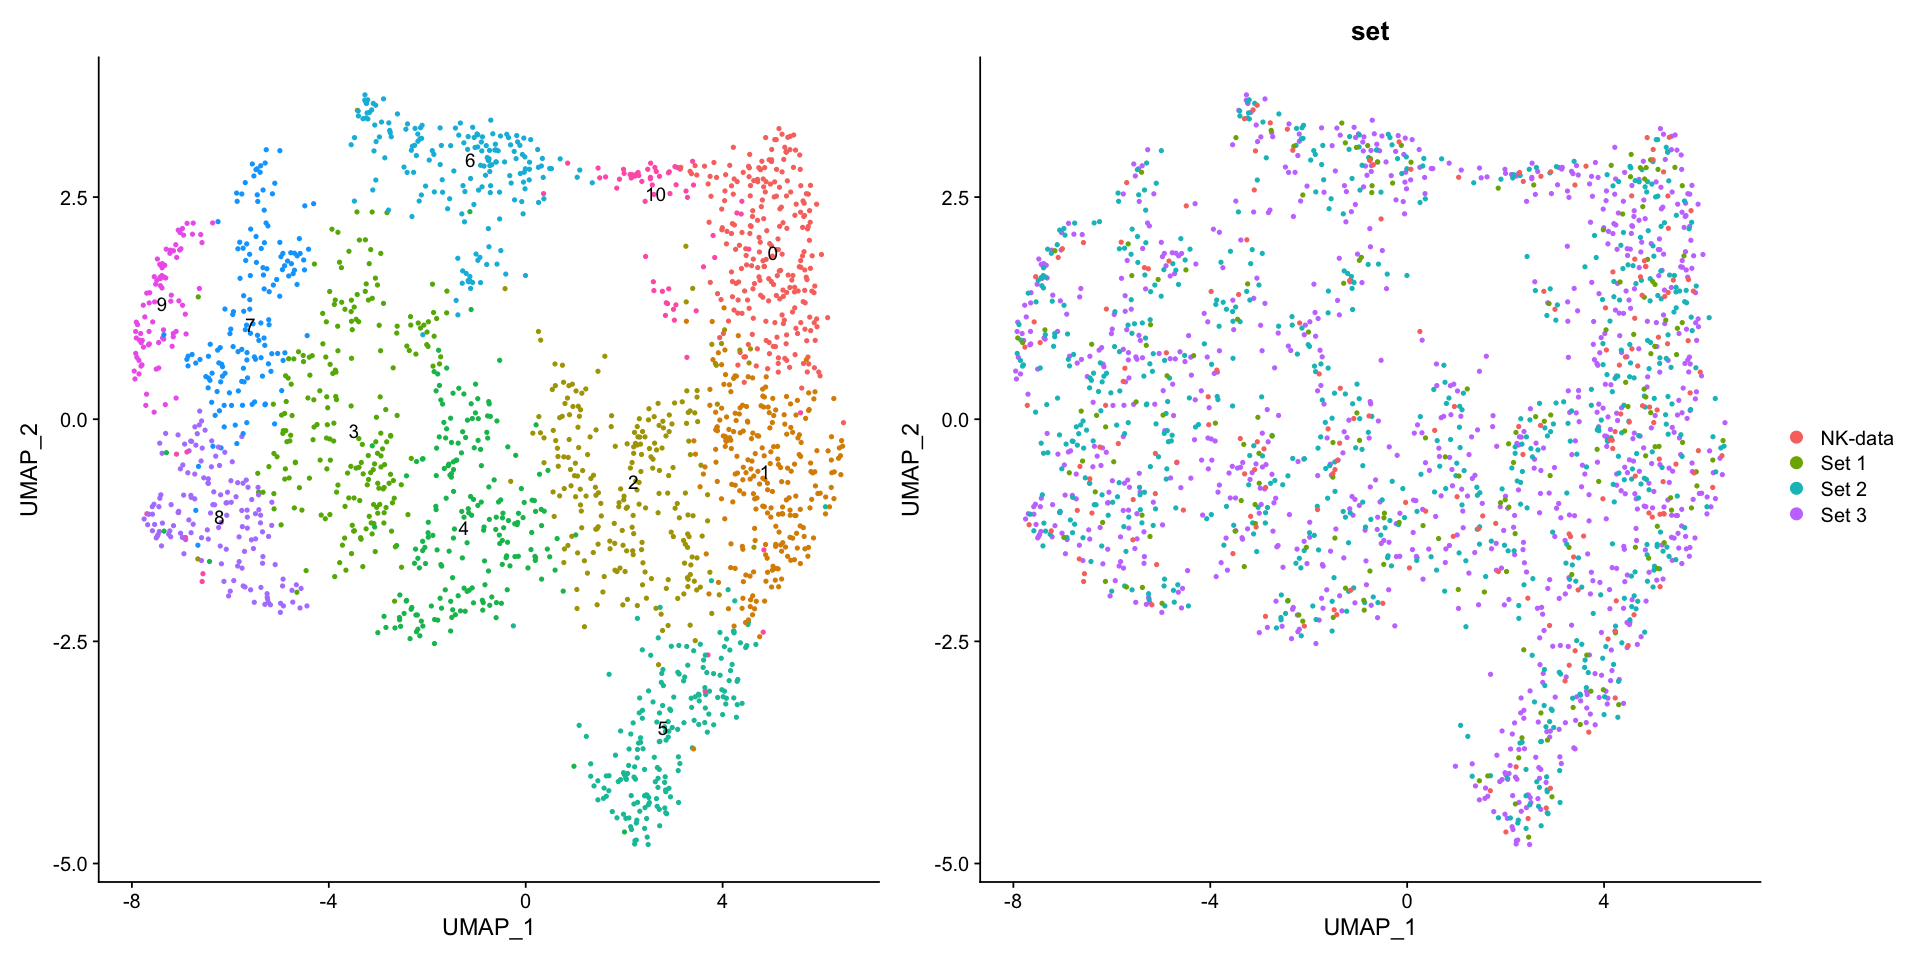

In [11]:
seu.post <- func.subclustering(seu.post, resolution = 1.3)

In [12]:
levels(seu.post) <- c(9,7,8,3,4,6,10,0,2,1,5)
all.markers <- FindAllMarkers(object = seu.post, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster 9

Calculating cluster 7

Calculating cluster 8

Calculating cluster 3

Calculating cluster 4

Calculating cluster 6

Calculating cluster 10

Calculating cluster 0

Calculating cluster 2

Calculating cluster 1

Calculating cluster 5



[1] 1873

[1] 110

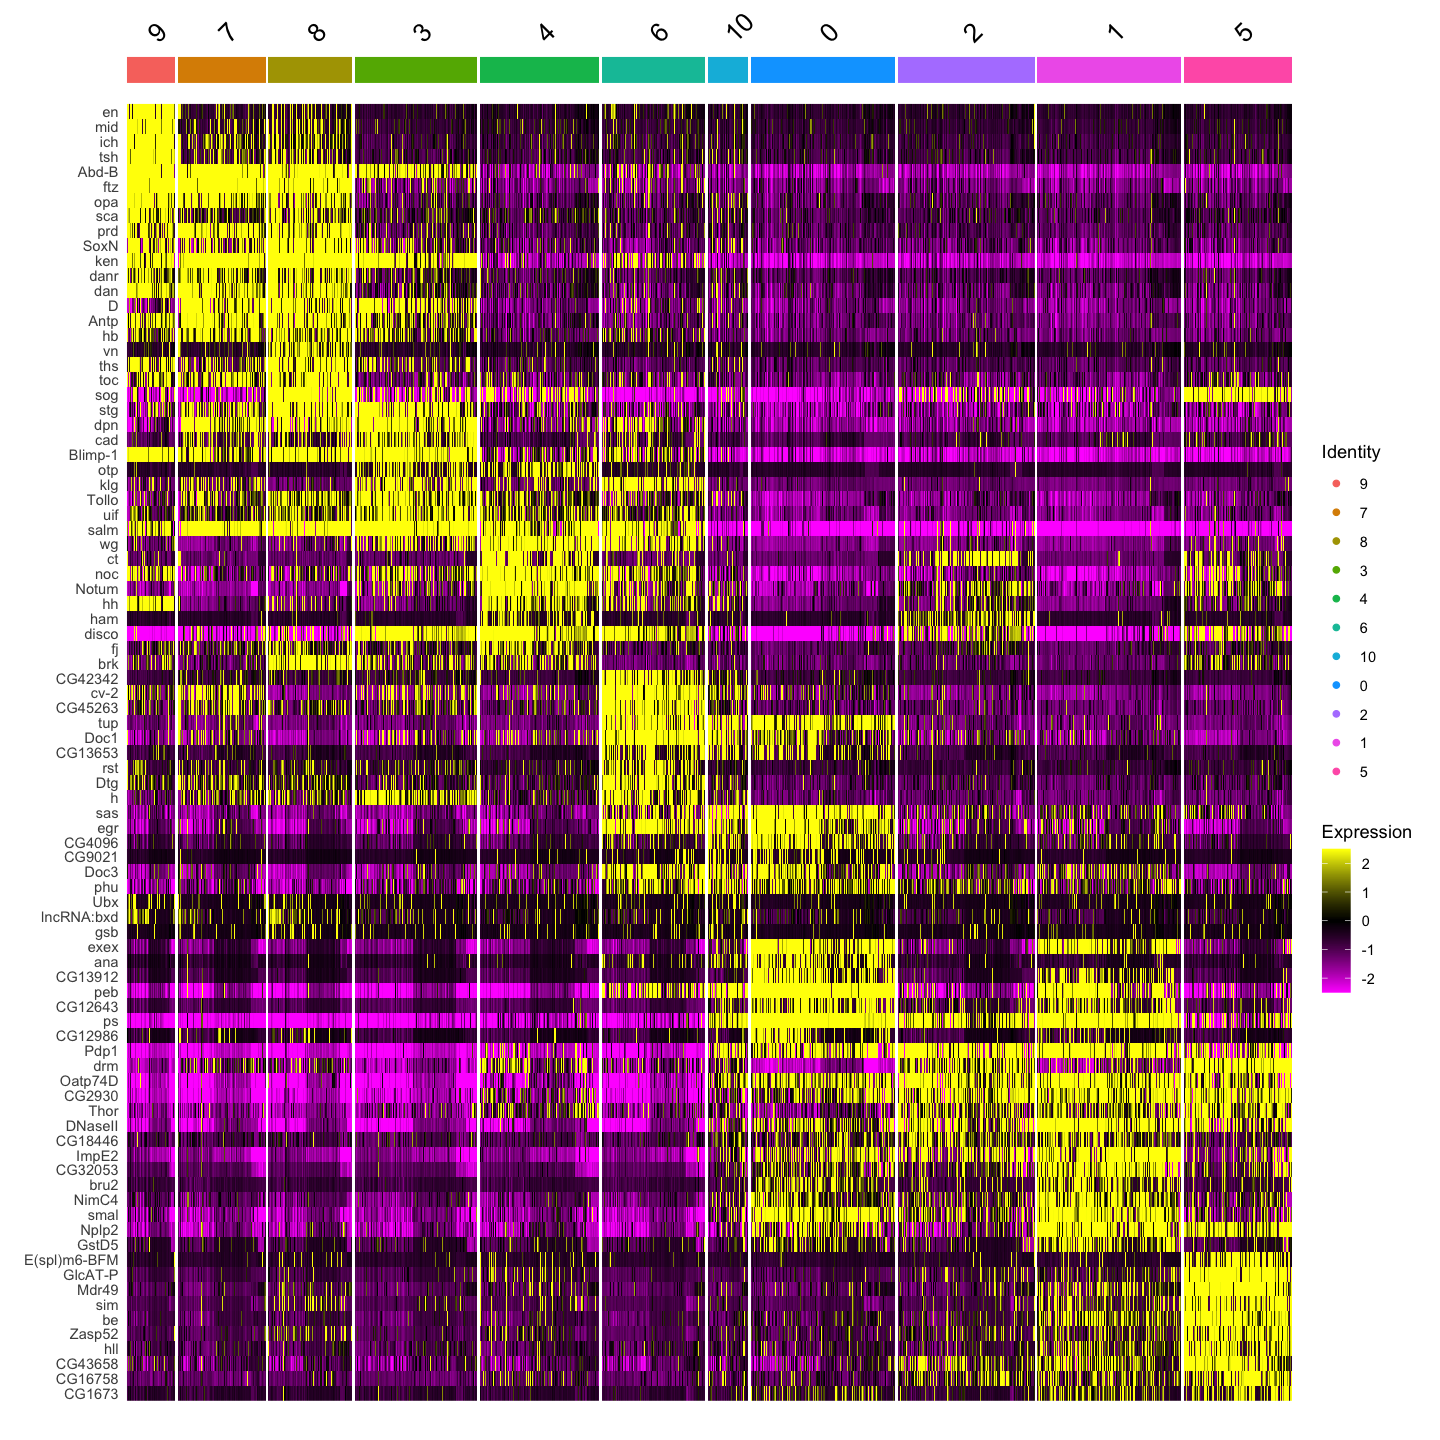

In [13]:
options(repr.plot.width=12, repr.plot.height=12)
DoHeatmap(seu.post, features = c(all.markers.top10$gene))

In [14]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu.post, reduction = 'umap', features = c('fkh', 'hkb', 'byn','Abd-B'))

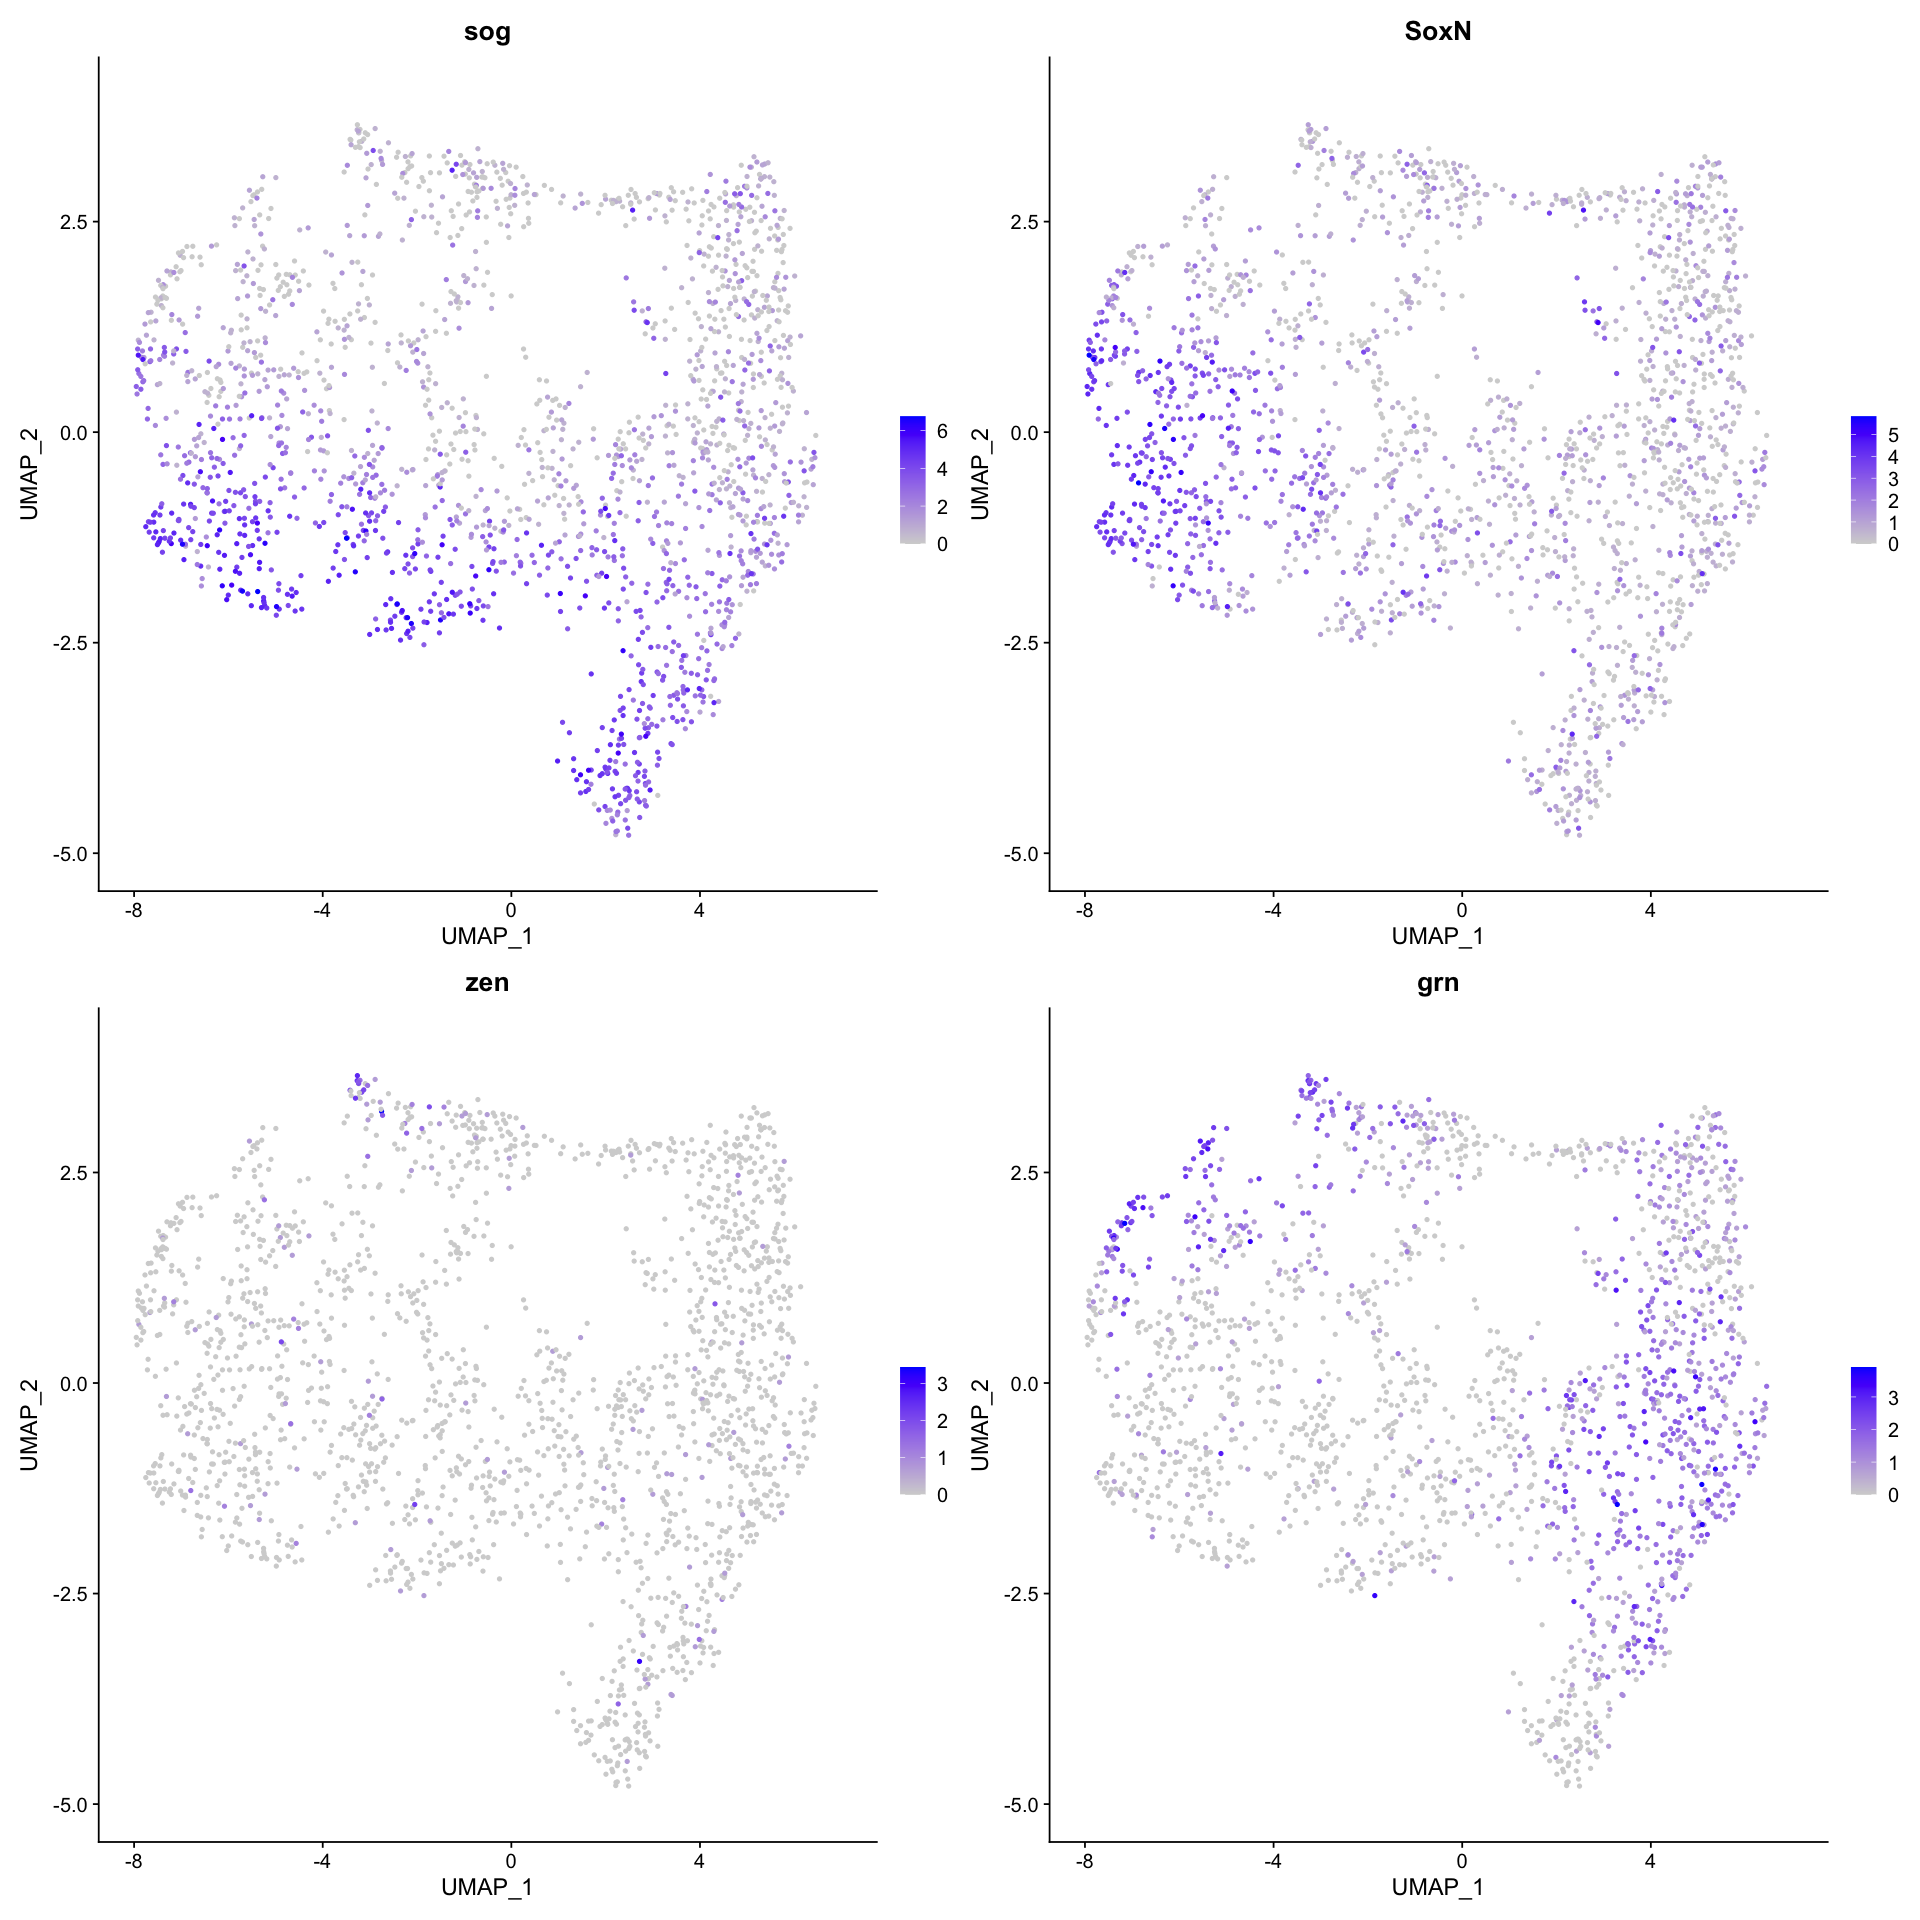

In [15]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu.post, reduction = 'umap', features = c('sog', 'SoxN', 'zen','grn'))

In [16]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu.post, reduction = 'umap', features = c('en', 'odd', 'run','slp1'))

## Add annotation

In [17]:
manual_id <- as.data.frame(seu.post$seurat_clusters)
colnames(manual_id) <- c('manual_ID')
head(manual_id)
manual_id$manual_ID = dplyr::recode(manual_id$manual_ID, 
                                     "0"="endoderm_postMG_dorsal", 
                                     "1"="endoderm_postMG_lateral",
                                     "2"="endoderm_postMG_lateral", 
                                     "3"="ectoderm_PS14/hindgut",
                                     "4"="ectoderm_hindgut_ventral",
                                     "5"="endoderm_postMG_ventral",
                                     "6"="ectoderm_hindgut_dorsal",
                                     "7"="ectoderm_PS14_dorsal",
                                     "8"="ectoderm_PS14_ventral",
                                     "9"="ectoderm_PS14_dorsal",
                                     "10"="endoderm_postMG_dorsal"
                                   )
                                    

head(manual_id)
seu.post$manual_ID <- manual_id
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu.post, reduction = 'umap', label = T, group.by = 'manual_ID') + NoLegend() 

manual_ID
Set3_CAGCACGAGTTACGGG 4        
Set3_AACACACAGTGATGGC 7        
Set3_ATCCACCAGTCACAGG 7        
Set3_ATTCTACTCCAGCACG 7        
Set3_CGGAATTTCAGTAGGG 7        
Set3_TATCGCCAGGGTGAGG 7

manual_ID               
Set3_CAGCACGAGTTACGGG ectoderm_hindgut_ventral
Set3_AACACACAGTGATGGC ectoderm_PS14_dorsal    
Set3_ATCCACCAGTCACAGG ectoderm_PS14_dorsal    
Set3_ATTCTACTCCAGCACG ectoderm_PS14_dorsal    
Set3_CGGAATTTCAGTAGGG ectoderm_PS14_dorsal    
Set3_TATCGCCAGGGTGAGG ectoderm_PS14_dorsal

In [18]:
Idents(seu.post) <- 'manual_ID'
levels(seu.post) <- c('ectoderm_PS14_ventral','ectoderm_PS14_dorsal',
                     'ectoderm_PS14/hindgut',
                     'ectoderm_hindgut_ventral','ectoderm_hindgut_dorsal',
                     'endoderm_postMG_ventral','endoderm_postMG_lateral','endoderm_postMG_dorsal')
levels(seu.post) 
all.markers <- FindAllMarkers(object = seu.post, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

[1] "ectoderm_PS14_ventral"    "ectoderm_PS14_dorsal"    
[3] "ectoderm_PS14/hindgut"    "ectoderm_hindgut_ventral"
[5] "ectoderm_hindgut_dorsal"  "endoderm_postMG_ventral" 
[7] "endoderm_postMG_lateral"  "endoderm_postMG_dorsal"

Calculating cluster ectoderm_PS14_ventral

Calculating cluster ectoderm_PS14_dorsal

Calculating cluster ectoderm_PS14/hindgut

Calculating cluster ectoderm_hindgut_ventral

Calculating cluster ectoderm_hindgut_dorsal

Calculating cluster endoderm_postMG_ventral

Calculating cluster endoderm_postMG_lateral

Calculating cluster endoderm_postMG_dorsal



[1] 1467

[1] 80

Saving 7 x 7 in image



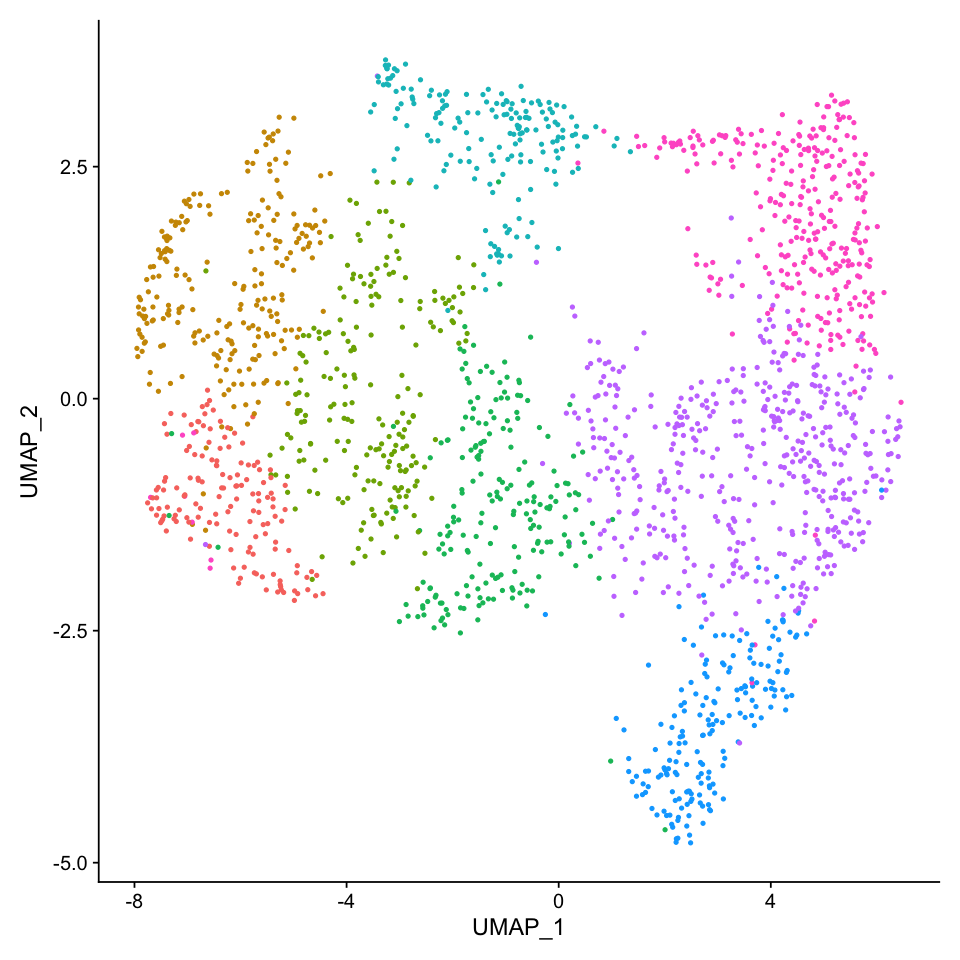

In [19]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.post, reduction =  "umap", label = FALSE) + NoLegend() 

fig
ggsave(fig, file = "./figures/05_post_subclustering_integrate_all/post_umap1.eps", dpi = 300)

In [20]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.post, reduction =  "umap", label = FALSE)

fig
ggsave(fig, file = "./figures/05_post_subclustering_integrate_all/post_umap2.eps", dpi = 300)

Saving 7 x 7 in image



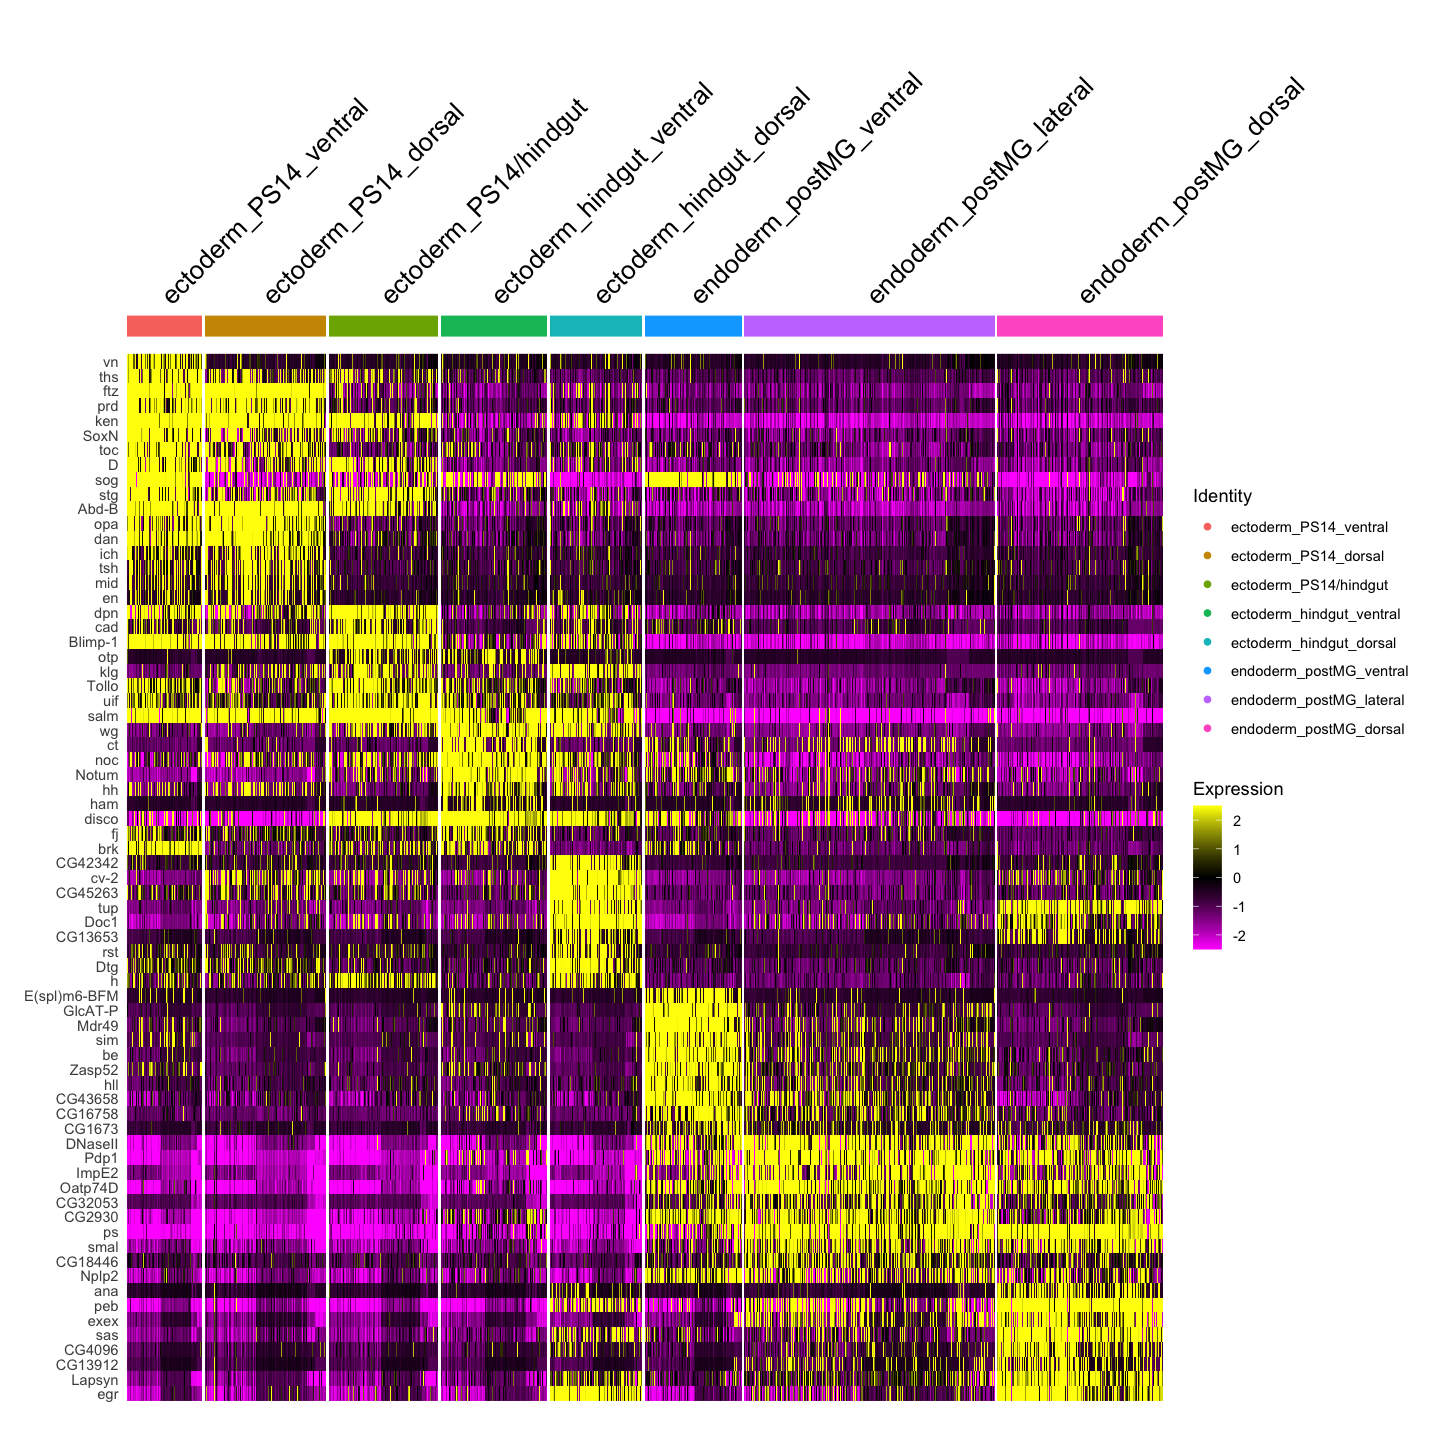

In [21]:
options(repr.plot.width=12, repr.plot.height=12)
fig <- DoHeatmap(seu.post, features = c(all.markers.top10$gene))
fig
ggsave(fig, file = "./figures/05_post_subclustering_integrate_all/post_manualID_heatmap.eps", dpi = 300,  width = 12, height = 8)

In [22]:
saveRDS(object = seu.post, file = '../../data/seurat_object/all_integration/subclustering/seu_post_subclustering.obj')